# Lemon Classifier Using ML frameworks in python

### Objectives:
* import the training dataset
* preprocess the training data
* train the model using ML framework
* validate / testing accuracy
* export model for microservice deployment
* have fun and enjoy a refeshing slice of lemon py :D
# 🍋

#### ========== Elliott M. Lynch 2/8/21 ==========

## framework selection considerations
in the contemporary context of ML frameworks in 2021, pytorch appears to be highly regarded,
for the purposes of this explorative notebook, demonstrating a binary image classifer in torch would be a suitable choice for this project's framework

In [186]:
# include module dependencies
import os
import torch
import numpy as np
import pandas as pd
from PIL import Image
from matplotlib import image
from matplotlib import pyplot
import cv2
from IPython.display import display # to display images in ipython notebook

### import training data
* the training data was curated from duckduckgo image searches 

In [187]:
# working with directories 

dir_name = "unprocessed-training/"
root = [dir_name + root for root in os.listdir(dir_name)]

""" training_set[0][:] contains positive examples & training_set[1][:] 
contains negative examples """
training_set_dir = [[],[]] 

index = -1
for branch in root:
    index += 1
    sub_dir = (os.listdir(branch))
    for img in sub_dir:
        training_set_dir[index].append(branch + "/" + img)
print(training_set_dir[1])


['unprocessed-training/negative/hfdshsdfsfkhj.png', 'unprocessed-training/negative/download - 2020-07-27T235330.775.png', 'unprocessed-training/negative/24245.png', 'unprocessed-training/negative/download - 2020-07-17T195255.025.png', 'unprocessed-training/negative/download (1).png', 'unprocessed-training/negative/download - 2020-07-27T235332.472.png', 'unprocessed-training/negative/download - 2020-07-27T235333.107.png', 'unprocessed-training/negative/download - 2020-07-27T235333.113.png', 'unprocessed-training/negative/download (22).png', 'unprocessed-training/negative/345345345.png', 'unprocessed-training/negative/download - 2020-07-27T235330.577.png', 'unprocessed-training/negative/download - 2020-07-17T194430.185.png', 'unprocessed-training/negative/download - 2020-07-27T235332.857.png', 'unprocessed-training/negative/download1111.png', 'unprocessed-training/negative/download (75).png', 'unprocessed-training/negative/ridle.png', 'unprocessed-training/negative/download (63).png', 'u

In [188]:
# converting directory to image set 
trainset_pos = [image.imread(img, 0) for img in training_set_dir[0]]
trainset_neg = [image.imread(img, 0) for img in training_set_dir[1]]


### testing our array training set to make sure it has been properly converted

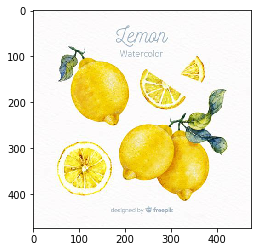

In [189]:
# display the array of pixels as an image
example = trainset_pos[0]
pyplot.imshow(example)
pyplot.show()


### experiment with manipulating an image

(195, 180, 3)


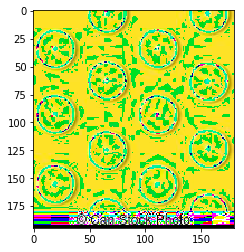

In [190]:
x = trainset_pos[1] + 1
y = np.array([[1, 2, 3], [4, 3, 2]])
print(x.shape) # print the dimension of the image
pyplot.imshow(x)
pyplot.show()

### array clip 
* clip the value of an array between a given range

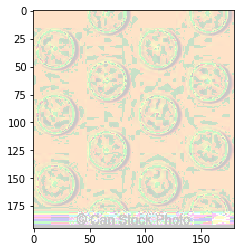

In [191]:
x1 = np.clip(x, 200, 255)
pyplot.imshow(x1)
pyplot.show()

### preprocess training data
* resize 
* greyscale
* denoise?

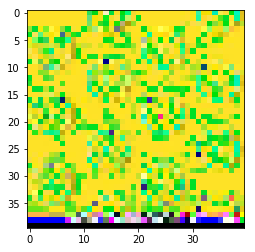

In [192]:
foo = cv2.resize(x, dsize=(40, 40), interpolation=cv2.INTER_CUBIC)
pyplot.imshow(foo)
pyplot.show()

### Resize images

In [181]:
image_dim = 40
trainset_pos = [cv2.resize(img, dsize=(image_dim, image_dim), interpolation=cv2.INTER_CUBIC) 
                for img in trainset_pos]
trainset_neg = [cv2.resize(img, dsize=(image_dim, image_dim), interpolation=cv2.INTER_CUBIC) 
                for img in trainset_neg]

### convert to greyscale

In [193]:
trainset_pos = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in trainset_pos]
trainset_neg = [cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) for img in trainset_neg]

### denoise

In [194]:
# TODO:

### display a preprocessed image

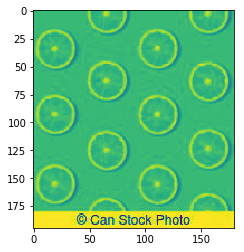

In [195]:
preprocessed_example = trainset_pos[1]
pyplot.imshow(preprocessed_example)
pyplot.show()

### testing PIL images

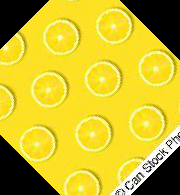

In [185]:
im = Image.open(training_set[0][1])
im_rot = im.rotate(45)
display(im_rot)

## train the model

## validation / performance testing

## results 

## exporting the model

## ML as a microservice through restful API's on the cloud

## Conclusion 
* thank you :D